# Отток клиентов

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


### Вывод

- Информация о структуре данных - двумерная(DataFrame);
- таблица имеет 10000 строк и 14 столбцов; 
- присутствуют названия столбцов и количество ненулевых значений;
- в таблице присутствуют значения типов int(8 столбцов), float(3 столбца), object(3 столбца);
- использование памяти.

In [4]:
data.columns = data.columns.str.lower()

Привела все столбцы к нижнему регистру.

In [5]:
data.isna().sum()

rownumber            0
customerid           0
surname              0
creditscore          0
geography            0
gender               0
age                  0
tenure             909
balance              0
numofproducts        0
hascrcard            0
isactivemember       0
estimatedsalary      0
exited               0
dtype: int64

Проверили датасет на пропуски, выявили, что пропуски есть в одном столбце и их нужно заполнить. На мой взгляд нет подходящего столбца, чтобы столбцы коррелировали между собой, но я решила сгруппировать по столбцу "Geography" и заполнить пробелы медианной.

In [6]:
data['tenure'] = np.where(data['tenure'].isna(), np.random.uniform(0.0, 10.0, size=len(data)), data['tenure'])

In [7]:
data['tenure'].isna().sum()

0

Удалим столбец "surname", "customerid" и "rownumber", так как в дальнейшем они нам не понадобиться и никак не повлияют на анализ и исследование данных. 

In [8]:
data = data.drop(['surname', 'customerid', 'rownumber'], axis=1)

Используем прямое кодирование для преобразования категориальных признаков в численные, а также избегаем дамми-ловушку:

In [9]:
data_ohe = pd.get_dummies(data, drop_first=True)

Разделим данные на обучающую, валидационную и тестовую выборки:

In [10]:
features = data_ohe.drop(['exited'], axis=1) #признаки
target = data_ohe['exited'] #целевой признак

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=0.2, random_state=12345)

display(features_train.shape)
display(target_train.shape)
display(features_valid.shape)
display(target_valid.shape)
display(features_test.shape)
display(target_test.shape)

(6400, 11)

(6400,)

(1600, 11)

(1600,)

(2000, 11)

(2000,)

In [11]:
numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

## Исследование задачи

### Логистическая регрессия

In [12]:
model_log_reg = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000)
model_log_reg.fit(features_train, target_train)
predicted_valid_log = model_log_reg.predict(features_valid)

display('F1-мера:', f1_score(target_valid, predicted_valid_log))

'F1-мера:'

0.3185011709601873

### Дерево решений

Ищем значения гиперпараметров для лучшей модели:

In [13]:
#model_tree = DecisionTreeClassifier(random_state=12345)

#parametrs = {'max_depth': range (1,16, 1)}
#model_tree_grid = GridSearchCV(model_tree, parametrs, cv=5)
#model_tree_grid.fit(features_train, target_train)

#display('Глубина дерева для лучшей модели:', model_tree_grid.best_params_)

#predicted_valid_tree = model_tree_grid.predict(features_valid)

Использовала сначала GridSearchCV, но у меня там получилось max_depth=6, а потом вот ниже я сделала уже циклом и max_depth=15 уже, я больше уверена в решении циклом поэтому оставила его и соответственно далее все искала также циклом.

In [14]:
best_model = None
best_result = 0
best_depth = 0
for depth in range(1, 16, 1):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree.fit(features_train, target_train)
    predicted_valid_tree = model_tree.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid_tree)
if f1 > best_result:
    best_model = model_tree
    best_result = f1
    best_depth = depth
display('Глубина дерева:', best_depth)
display('F1-мера:', best_result)

'Глубина дерева:'

15

'F1-мера:'

0.4907563025210084

### Случайный лес

In [15]:
#%%time

#model_forest = RandomForestClassifier(random_state=12345)

#parametrs = {'max_depth': range (1,16, 2), 'n_estimators': range (10, 101, 10)}
#model_forest_grid = GridSearchCV(model_forest, parametrs, cv=5)
#model_forest_grid.fit(features_train, target_train)

#display('Глубина дерева и количество деревьев для лучшей модели:', model_forest_grid.best_params_)

#predicted_valid_forest = model_forest_grid.predict(features_valid)

In [16]:
%%time

best_model = None
best_result = 0
best_est = 0
best_depth = 0
for depth in range(1, 16, 1):
    for est in range(1, 101, 10):
        model_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_forest.fit(features_train, target_train)
        predicted_valid_forest = model_forest.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid_forest)
    if f1 > best_result:
        best_model = model_forest
        best_result = f1
        best_est = est
        best_depth = depth
display('Глубина дерева:', best_depth)
display('Количество деревьев:', best_est)
display('F1-мера:', best_result)

'Глубина дерева:'

14

'Количество деревьев:'

91

'F1-мера:'

0.5755102040816327

CPU times: user 33.5 s, sys: 146 ms, total: 33.7 s
Wall time: 34 s


### Вывод

Для проведения исследования использовали три модели - Дерево решений, Случайный лес и Логистическую регрессию. Для того, чтобы выявить лучшую модель пользовалась циклом для нахождения значений гиперпараметров. После исследования выявилось, что лучшая модель это Случайный лес.

## Борьба с дисбалансом

Бороться с дисбалансом можно 3-я способами: взвешивание классов, увеличение/уменьшение выборки:

### Логистическая регрессия

#### Взвешивание классов

In [17]:
model_log_weight = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced', max_iter=1000)
model_log_weight.fit(features_train, target_train)
predicted_valid_log_weight = model_log_weight.predict(features_valid)
print("F1-мера:", f1_score(target_valid, predicted_valid_log_weight))

F1-мера: 0.46432616081540207


#### Увеличение выборки

In [18]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

In [19]:
model_log_up = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000)
model_log_up.fit(features_upsampled, target_upsampled)
predicted_valid_log_up = model_log_up.predict(features_valid)

display('F1-мера:', f1_score(target_valid, predicted_valid_log_up))

'F1-мера:'

0.46480743691899074

#### Уменьшение выборки

In [20]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345), features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345), target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.3)

In [21]:
model_log_down = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000)
model_log_down.fit(features_downsampled, target_downsampled)
predicted_valid_log_down = model_log_down.predict(features_valid)

display('F1-мера:', f1_score(target_valid, predicted_valid_log_down))

'F1-мера:'

0.46249999999999997

In [22]:
#код ревьюера
target_downsampled.value_counts()

0    1528
1    1307
Name: exited, dtype: int64

#### Изменение порога

array([0.18973075, 0.18922306, 0.18934169, ..., 0.5       , 1.        ,
       1.        ])

array([1.        , 0.99669967, 0.99669967, ..., 0.00330033, 0.00330033,
       0.        ])

array([0.01803153, 0.01855005, 0.01887237, ..., 0.82760578, 0.83381373,
       0.88017735])

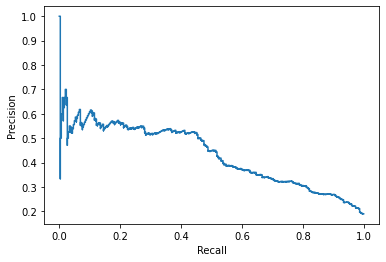

In [23]:
model_log_threshold = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000)
model_log_threshold.fit(features_train, target_train)
proba_valid_log_threshold = model_log_threshold.predict_proba(features_valid)
proba_one_valid_log_threshold = proba_valid_log_threshold[:, 1]

precision, recall, thresholds = precision_recall_curve(target_valid, proba_one_valid_log_threshold)

display(precision)
display(recall)
display(thresholds)

disp_log = PrecisionRecallDisplay(precision=precision, recall=recall)
disp_log.plot()
plt.show()

#### Расчет AUC-ROC

0.7624322185495342

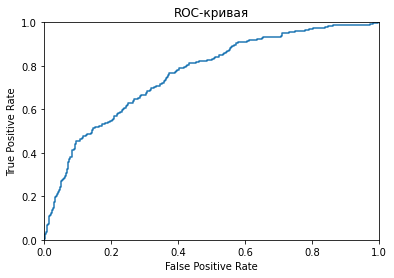

In [24]:
model_log_threshold = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000)
model_log_threshold.fit(features_train, target_train)
proba_valid_log_threshold = model_log_threshold.predict_proba(features_valid)
proba_one_valid_log_threshold = proba_valid_log_threshold[:, 1]

auc_roc = roc_auc_score(target_valid, proba_one_valid_log_threshold)
display(auc_roc)

fpr, tpr, thresholds = roc_curve(target_valid, proba_one_valid_log_threshold)

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

### Дерево решений

#### Взвешивание классов

In [25]:
best_model = None
best_result = 0
best_depth = 0
for depth in range(1, 16, 1):
    model_tree_weight = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model_tree_weight.fit(features_train, target_train)
    predicted_valid_tree_weight = model_tree_weight.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid_tree_weight)
if f1 > best_result:
    best_model = model_tree_weight
    best_result = f1
    best_depth = depth
display('Глубина дерева:', best_depth)
display('F1-мера:', best_result)

'Глубина дерева:'

15

'F1-мера:'

0.48062015503875966

#### Увеличение выборки

In [26]:
best_model = None
best_result = 0
best_depth = 0
for depth in range(1, 16, 1):
    model_tree_up = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree_up.fit(features_upsampled, target_upsampled)
    predicted_valid_tree_up = model_tree_up.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid_tree_up)
if f1 > best_result:
    best_model = model_tree_up
    best_result = f1
    best_depth = depth
display('Глубина дерева:', best_depth)
display('F1-мера:', best_result)

'Глубина дерева:'

15

'F1-мера:'

0.499194847020934

#### Уменьшение выборки

In [27]:
best_model = None
best_result = 0
best_depth = 0
for depth in range(1, 16, 1):
    model_tree_down = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree_down.fit(features_downsampled, target_downsampled)
    predicted_valid_tree_down = model_tree_down.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid_tree_down)
if f1 > best_result:
    best_model = model_tree_down
    best_result = f1
    best_depth = depth
display('Глубина дерева:', best_depth)
display('F1-мера:', best_result)

'Глубина дерева:'

15

'F1-мера:'

0.4556074766355141

#### Изменение порога

array([0.189375  , 0.33914729, 0.35282258, 0.35787321, 0.375     ,
       0.37336245, 0.37527594, 0.37946429, 0.39170507, 0.39534884,
       0.39906103, 0.39858491, 0.40047393, 0.40487805, 0.40694789,
       0.41057935, 0.41071429, 0.41602067, 0.42133333, 0.43977591,
       0.43352601, 0.43604651, 0.45259939, 0.45538462, 0.45510836,
       0.46945338, 0.47712418, 0.48026316, 0.49659864, 0.5       ,
       0.50694444, 0.50877193, 0.51236749, 0.51601423, 1.        ])

array([1.        , 0.57755776, 0.57755776, 0.57755776, 0.57425743,
       0.56435644, 0.56105611, 0.56105611, 0.56105611, 0.56105611,
       0.56105611, 0.55775578, 0.55775578, 0.54785479, 0.54125413,
       0.5379538 , 0.53135314, 0.53135314, 0.52145215, 0.51815182,
       0.4950495 , 0.4950495 , 0.48844884, 0.48844884, 0.48514851,
       0.48184818, 0.48184818, 0.48184818, 0.48184818, 0.48184818,
       0.48184818, 0.47854785, 0.47854785, 0.47854785, 0.        ])

array([0.        , 0.01369863, 0.02439024, 0.03225806, 0.04347826,
       0.05882353, 0.06666667, 0.06896552, 0.07142857, 0.07407407,
       0.07692308, 0.12      , 0.13333333, 0.13636364, 0.13888889,
       0.13953488, 0.14285714, 0.15555556, 0.16438356, 0.16666667,
       0.21428571, 0.27868852, 0.28571429, 0.30769231, 0.33333333,
       0.36363636, 0.4       , 0.42857143, 0.5       , 0.53333333,
       0.625     , 0.66666667, 0.75      , 1.        ])

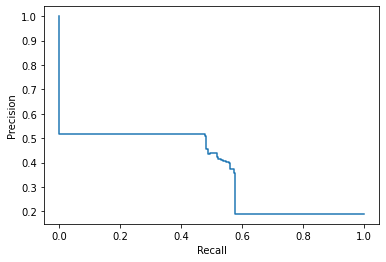

In [28]:
model_tree_threshold = DecisionTreeClassifier(random_state=12345, max_depth=15)
model_tree_threshold.fit(features_train, target_train)
proba_valid_tree_threshold = model_tree_threshold.predict_proba(features_valid)
proba_one_valid_tree_threshold = proba_valid_tree_threshold[:, 1]

precision, recall, thresholds = precision_recall_curve(target_valid, proba_one_valid_tree_threshold)

display(precision)
display(recall)
display(thresholds)

disp_tree = PrecisionRecallDisplay(precision=precision, recall=recall)
disp_tree.plot()
plt.show()

#### Расчет AUC-ROC

0.6909598438641089

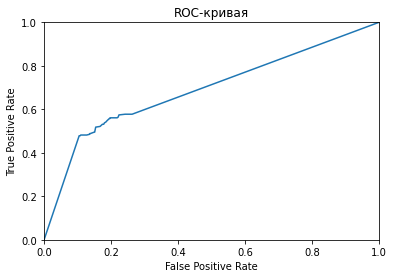

In [29]:
model_tree_threshold = DecisionTreeClassifier(random_state=12345, max_depth=15)
model_tree_threshold.fit(features_train, target_train)
proba_valid_tree_threshold = model_tree_threshold.predict_proba(features_valid)
proba_one_valid_tree_threshold = proba_valid_tree_threshold[:, 1]

auc_roc = roc_auc_score(target_valid, proba_one_valid_tree_threshold)
display(auc_roc)

fpr, tpr, thresholds = roc_curve(target_valid, proba_one_valid_tree_threshold)

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

### Случайный лес

#### Взвешивание классов

In [30]:
%%time

best_model = None
best_result = 0
best_est = 0
best_depth = 0
for depth in range(1, 16, 1):
    for est in range(1, 101, 10):
        model_forest_weight = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced')
        model_forest_weight.fit(features_train, target_train)
        predicted_valid_forest_weight = model_forest_weight.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid_forest_weight)
    if f1 > best_result:
        best_model = model_forest_weight
        best_result = f1
        best_est = est
        best_depth = depth
display('Глубина дерева:', best_depth)
display('Количество деревьев:', best_est)
display('F1-мера:', best_result)

'Глубина дерева:'

9

'Количество деревьев:'

91

'F1-мера:'

0.6036036036036037

CPU times: user 33.2 s, sys: 97.8 ms, total: 33.3 s
Wall time: 33.8 s


#### Увеличение выборки

In [31]:
%%time

best_model = None
best_result = 0
best_est = 0
best_depth = 0
for depth in range(1, 16, 1):
    for est in range(1, 101, 10):
        model_forest_up = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_forest_up.fit(features_upsampled, target_upsampled)
        predicted_valid_forest_up = model_forest_up.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid_forest_up)
    if f1 > best_result:
        best_model = model_forest_up
        best_result = f1
        best_est = est
        best_depth = depth
display('Глубина дерева:', best_depth)
display('Количество деревьев:', best_est)
display('F1-мера:', best_result)

'Глубина дерева:'

12

'Количество деревьев:'

91

'F1-мера:'

0.6125827814569536

CPU times: user 42.9 s, sys: 135 ms, total: 43.1 s
Wall time: 43.4 s


#### Уменьшение выборки

In [32]:
%%time

best_model = None
best_result = 0
best_est = 0
best_depth = 0
for depth in range(1, 16, 1):
    for est in range(1, 101, 10):
        model_forest_down = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_forest_down.fit(features_downsampled, target_downsampled)
        predicted_valid_forest_down = model_forest_down.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid_forest_down)
    if f1 > best_result:
        best_model = model_forest_down
        best_result = f1
        best_est = est
        best_depth = depth
display('Глубина дерева:', best_depth)
display('Количество деревьев:', best_est)
display('F1-мера:', best_result)

'Глубина дерева:'

7

'Количество деревьев:'

91

'F1-мера:'

0.5854341736694679

CPU times: user 20.1 s, sys: 91.7 ms, total: 20.2 s
Wall time: 20.2 s


#### Изменение порога

array([0.18973075, 0.18922306, 0.18934169, ..., 1.        , 1.        ,
       1.        ])

array([1.        , 0.99669967, 0.99669967, ..., 0.00660066, 0.00330033,
       0.        ])

array([0.00628632, 0.00758342, 0.00775188, ..., 0.9496337 , 0.96428571,
       0.97387057])

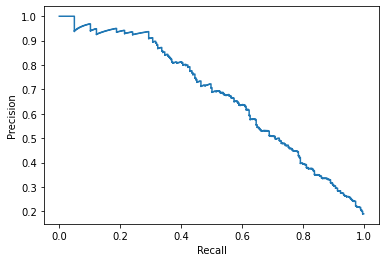

CPU times: user 670 ms, sys: 20.1 ms, total: 690 ms
Wall time: 695 ms


In [40]:
%%time

model_forest_threshold = RandomForestClassifier(random_state=12345, max_depth=12, n_estimators=91)
model_forest_threshold.fit(features_train, target_train)
proba_valid_forest_threshold = model_forest_threshold.predict_proba(features_valid)
proba_one_valid_forest_threshold = proba_valid_forest_threshold[:, 1]

precision, recall, thresholds = precision_recall_curve(target_valid, proba_one_valid_forest_threshold)

display(precision)
display(recall)
display(thresholds)

disp_forest = PrecisionRecallDisplay(precision=precision, recall=recall)
disp_forest.plot()
plt.show()

#### Расчет AUC-ROC

0.8518871933453946

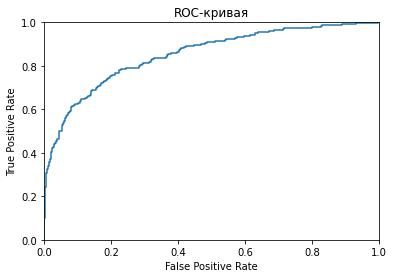

CPU times: user 671 ms, sys: 4.03 ms, total: 675 ms
Wall time: 677 ms


In [41]:
%%time

model_forest_threshold = RandomForestClassifier(random_state=12345, max_depth=12, n_estimators=91)
model_forest_threshold.fit(features_train, target_train)
proba_valid_forest_threshold = model_forest_threshold.predict_proba(features_valid)
proba_one_valid_forest_threshold = proba_valid_forest_threshold[:, 1]

auc_roc = roc_auc_score(target_valid, proba_one_valid_forest_threshold)
display(auc_roc)

fpr, tpr, thresholds = roc_curve(target_valid, proba_one_valid_forest_threshold)

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

Вывод:

Наблюдаем, что когда применяли Взвешивание классов, то наилучшей моделью стала "Случайный лес" - F1-мера достигла 0.60.Когда делали увеличение выборки, то лучшей моделью также стала "Случайный лес" - F1-мера - 0.61, когда делали уменьшение выборки, то лучшей моделью также стала "Случайный лес", но F1-мера намного меньше - 0.44.

Если увеличивать порог, то точность будет увеличиваться, а полнота уменьшаться, что и наблюдается выше.

Метрика AUC-ROC имеет вероятностный смысл: это вероятность того, что случайно взятый объект класса 1 имеет оценку принадлежности к классу 1 выше, чем случайно взятый объект класса 0.

Объединим тренировочную и валидационную выборки:

In [42]:
features_train_valid = pd.concat([features_train, features_valid])
target_train_valid = pd.concat([target_train, target_valid])

display(features_train_valid.shape)
display(target_train_valid.shape)

(8000, 11)

(8000,)

## Тестирование модели

Тестировать данные будем на модели "Случайный лес" так как она показала лучшие результаты:

In [39]:
#model_forest_test = RandomForestClassifier(random_state=12345, max_depth=11, n_estimators=91)
#model_forest_test.fit(features_train_valid, target_train_valid)
#predicted_valid_forest_test = model_forest_test.predict(features_test)
#display('F1-мера:', f1_score(target_test, predicted_valid_forest_test))

In [37]:
pd.options.mode.chained_assignment = None
features_test[numeric] = scaler.transform(features_test[numeric])

In [43]:
model_forest_test = RandomForestClassifier(random_state=12345, max_depth=12, n_estimators=91, class_weight='balanced')
model_forest_test.fit(features_train_valid, target_train_valid)
predicted_valid_forest_test = model_forest_test.predict(features_test)
display('F1-мера:', f1_score(target_test, predicted_valid_forest_test))

'F1-мера:'

0.6256281407035176